# 08 Geostatistics demo

## Overview
This notebook explores fundamental geostatistical concepts using the GLAS elevation data from lab02

We'll explore key geostatistical techniques:
1. Spatial autocorrelation (Global and Local Moran's I)
2. Variogram analysis
3. Spatial interpolation (deterministic vs. kriging)

## Imports

In [ ]:
# !pip install pysal
# !pip install scikit-gstat

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
import os
from pathlib import Path
import warnings

# Geospatial libraries
import geopandas as gpd
import xarray as xr
import rasterio
import rioxarray as rxr
from pyproj import CRS
import contextily as ctx
from shapely.geometry import Point, Polygon

# Geostatistical libraries
import pysal
from pysal.explore import esda
from pysal.lib import weights
from splot.esda import moran_scatterplot
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import skgstat as skg

import easysnowdata

/home/eric/miniconda3/envs/uwgda2025/lib/python3.12/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


## Geostatistics with vector data

In [2]:
WUS_aea_crs = "+proj=aea +lon_0=-111.2695312 +lat_1=33.5538453 +lat_2=46.581155 +lat_0=40.0675002 +datum=WGS84 +units=m +no_defs"
glas_df = pd.read_csv('../02_NumPy_Pandas_Matplotlib/data/GLAH14_tllz_conus_lulcfilt_demfilt.csv')
glas_gdf = gpd.GeoDataFrame(glas_df, geometry=gpd.points_from_xy(glas_df.lon, glas_df.lat)).set_crs('EPSG:4326')
glas_gdf = glas_gdf.to_crs(WUS_aea_crs)
glas_gdf

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,geometry
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,POINT (470693.831 472504.893)
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,POINT (470627.12 471636.996)
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,POINT (470613.749 471463.57)
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,POINT (470600.39 471289.921)
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,POINT (470587.11 471116.278)
...,...,...,...,...,...,...,...,...,...
65231,2009.775995,733691.238340,37.896222,-117.044399,1556.16,1556.43,0.00,31,POINT (-504775.82 -226245.044)
65232,2009.775995,733691.238340,37.897769,-117.044675,1556.02,1556.43,0.00,31,POINT (-504788.788 -226071.184)
65233,2009.775995,733691.238340,37.899319,-117.044952,1556.19,1556.44,0.00,31,POINT (-504801.821 -225896.984)
65234,2009.775995,733691.238340,37.900869,-117.045230,1556.18,1556.44,0.00,31,POINT (-504814.94 -225722.778)


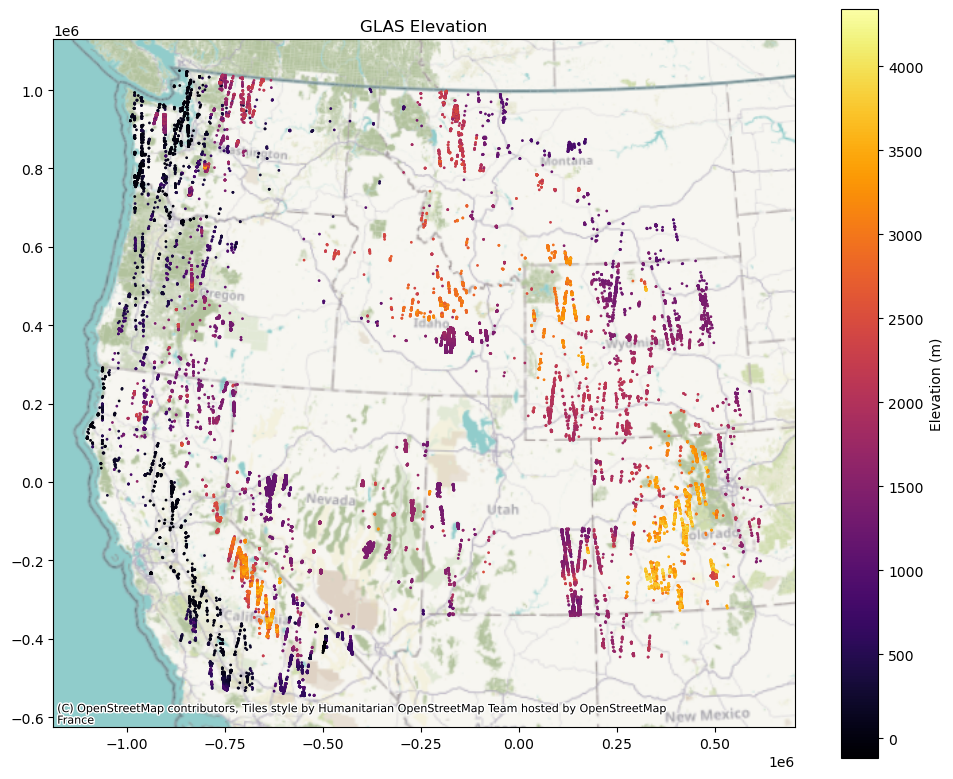

In [3]:
f,ax=plt.subplots(figsize=(10,8))

glas_gdf.plot(ax=ax,column='glas_z',cmap='inferno',legend=True,markersize=1,legend_kwds={'label': "Elevation (m)"})
ctx.add_basemap(ax,crs=glas_gdf.crs.to_string())

ax.set_aspect('equal')

ax.set_title('GLAS Elevation')

f.tight_layout()

### Regular correlation - comparing glas_z and dem_z values

In [4]:
corr = glas_gdf.corr(numeric_only=True)
corr

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc
decyear,1.000000,1.000000,-0.030542,0.022455,-0.010960,-0.011376,-0.023535,-0.006947
ordinal,1.000000,1.000000,-0.030537,0.022457,-0.010963,-0.011379,-0.023538,-0.006953
lat,-0.030542,-0.030537,1.000000,-0.159387,-0.112952,-0.113471,0.103647,-0.111976
lon,0.022455,0.022457,-0.159387,1.000000,0.507210,0.507571,0.141909,-0.073070
glas_z,-0.010960,-0.010963,-0.112952,0.507210,1.000000,0.999929,0.588513,-0.206267
dem_z,-0.011376,-0.011379,-0.113471,0.507571,0.999929,1.000000,0.589164,-0.206353
dem_z_std,-0.023535,-0.023538,0.103647,0.141909,0.588513,0.589164,1.000000,-0.106402
lulc,-0.006947,-0.006953,-0.111976,-0.073070,-0.206267,-0.206353,-0.106402,1.000000


In [5]:
m,b = np.polyfit(glas_gdf['glas_z'], glas_gdf['dem_z'], 1)

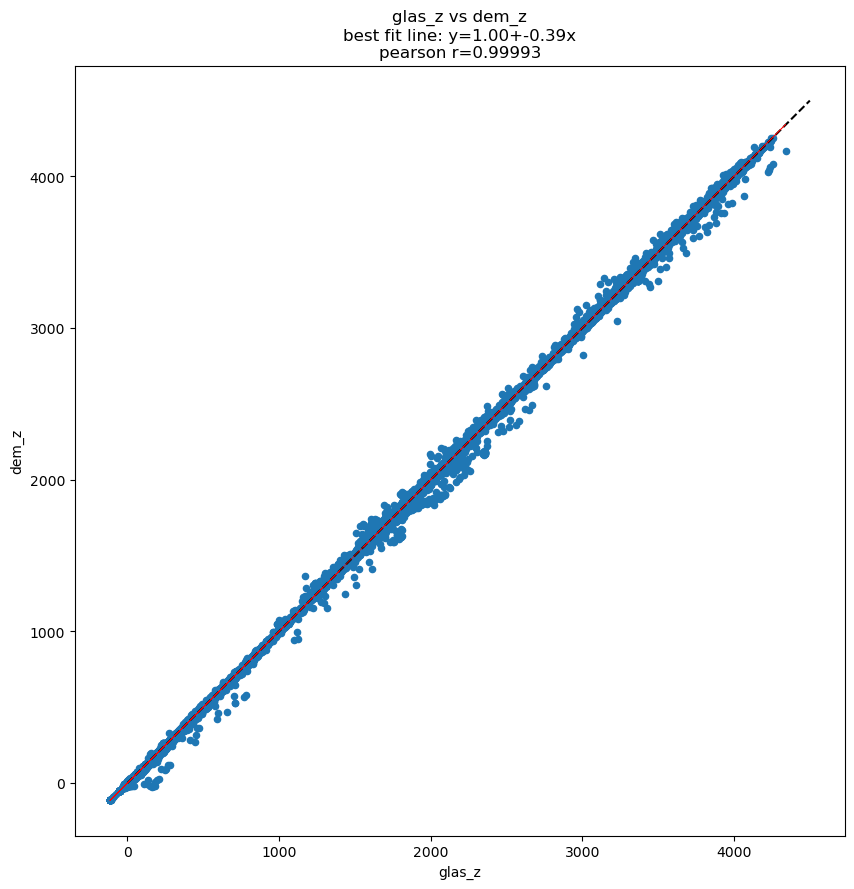

In [6]:
f,ax=plt.subplots(figsize=(10,10))
glas_gdf.plot(x='glas_z', y='dem_z', kind='scatter', ax=ax)
ax.set_aspect('equal')
ax.plot([0, 4500], [0, 4500], color='black', linestyle='--')
ax.set_title(f'glas_z vs dem_z\nbest fit line: y={m:.2f}+{b:.2f}x\npearson r={corr.loc["glas_z","dem_z"]:.5f}')
ax.plot(glas_gdf['glas_z'], m*glas_gdf['glas_z']+b, color='red',linewidth=0.5)


### Spatial autocorrelation - Global Moran's I
#### First, we'll take a sample of our points and create a spatial weights matrix

In [7]:
sample_size = min(10000, len(glas_gdf))  # Adjust based on computational resources
glas_sample = glas_gdf.sample(sample_size, random_state=42)

# Create a spatial weights matrix
# We'll use k-nearest neighbors (KNN) weights
k = 8  # Number of neighbors
knn_w = weights.KNN.from_dataframe(glas_sample, k=k)
knn_w = weights.distance.DistanceBand.from_dataframe(glas_sample, threshold=50000)
knn_w.transform = 'r'  

/home/eric/miniconda3/envs/uwgda2025/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 70 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/home/eric/miniconda3/envs/uwgda2025/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 45 disconnected components.
 There are 11 islands with ids: 8375, 50437, 21349, 59942, 44611, 10852, 19313, 22379, 58096, 21543, 2721.
  w = W(neighbors, weights, ids, **kwargs)


('WARNING: ', 8375, ' is an island (no neighbors)')
('WARNING: ', 50437, ' is an island (no neighbors)')
('WARNING: ', 21349, ' is an island (no neighbors)')
('WARNING: ', 59942, ' is an island (no neighbors)')
('WARNING: ', 44611, ' is an island (no neighbors)')
('WARNING: ', 10852, ' is an island (no neighbors)')
('WARNING: ', 19313, ' is an island (no neighbors)')
('WARNING: ', 22379, ' is an island (no neighbors)')
('WARNING: ', 58096, ' is an island (no neighbors)')
('WARNING: ', 21543, ' is an island (no neighbors)')
('WARNING: ', 2721, ' is an island (no neighbors)')


/home/eric/miniconda3/envs/uwgda2025/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 45 disconnected components.
 There are 11 islands with ids: 8375, 50437, 21349, 59942, 44611, 10852, 19313, 22379, 58096, 21543, 2721.
  W.__init__(


In [8]:
# Check if the weights matrix is proper
print(f"Weights matrix properties:")
print(f"Number of observations: {knn_w.n}")
print(f"Number of neighbors per observation: {k}")

Weights matrix properties:
Number of observations: 10000
Number of neighbors per observation: 8


#### Now let's calculate Global Moran's I and interpret

In [9]:
y = glas_sample['glas_z']
moran = esda.Moran(y, knn_w)

print(f"Global Moran's I: {moran.I:.3f}")
print(f"p-value: {moran.p_sim:.3f}")
print(f"z-score: {moran.z_sim:.3f}")

Global Moran's I: 0.928
p-value: 0.001
z-score: 497.042


In [10]:
if moran.p_sim < 0.05:
    if moran.I > 0:
        print("There is statistically significant positive spatial autocorrelation in elevation values.")
        print("This means that similar elevation values tend to cluster together spatially.")
    else:
        print("There is statistically significant negative spatial autocorrelation in elevation values.")
        print("This means that dissimilar elevation values tend to be near each other (checkerboard pattern).")
else:
    print("There is no statistically significant spatial autocorrelation in elevation values.")
    print("The spatial distribution of elevation values appears to be random.")

There is statistically significant positive spatial autocorrelation in elevation values.
This means that similar elevation values tend to cluster together spatially.


/tmp/ipykernel_3086994/895129676.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(moran.sim,shade=True,ax=ax)


Text(0.5, 1.0, "Moran's I Simulation Distribution")

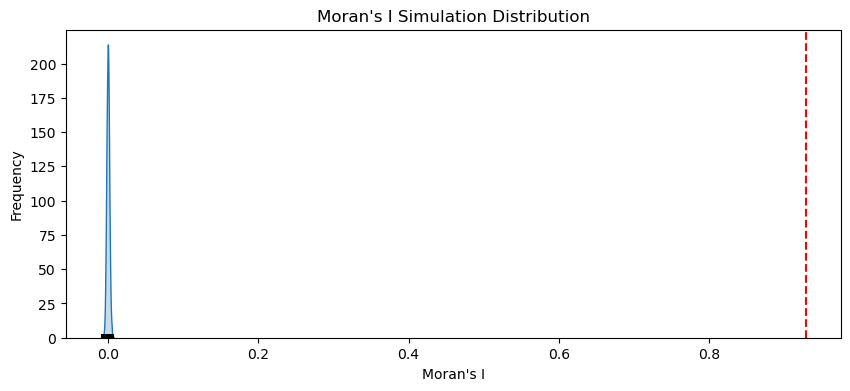

In [11]:
f,ax=plt.subplots(figsize=(10,4))
sns.kdeplot(moran.sim,shade=True,ax=ax)
ax.axvline(moran.I,color='red',linestyle='--')
ax.vlines(moran.sim,ymin=0,ymax=3,color='black')
ax.set_xlabel('Moran\'s I')
ax.set_ylabel('Frequency')
ax.set_title('Moran\'s I Simulation Distribution')

/home/eric/miniconda3/envs/uwgda2025/lib/python3.12/site-packages/splot/_viz_esda_mpl.py:131: UserWarning: `p` is only used for plotting `esda.moran.Moran_Local`
or `Moran_Local_BV` objects
  warnings.warn(


Text(0.65, 0.05, 'HL')

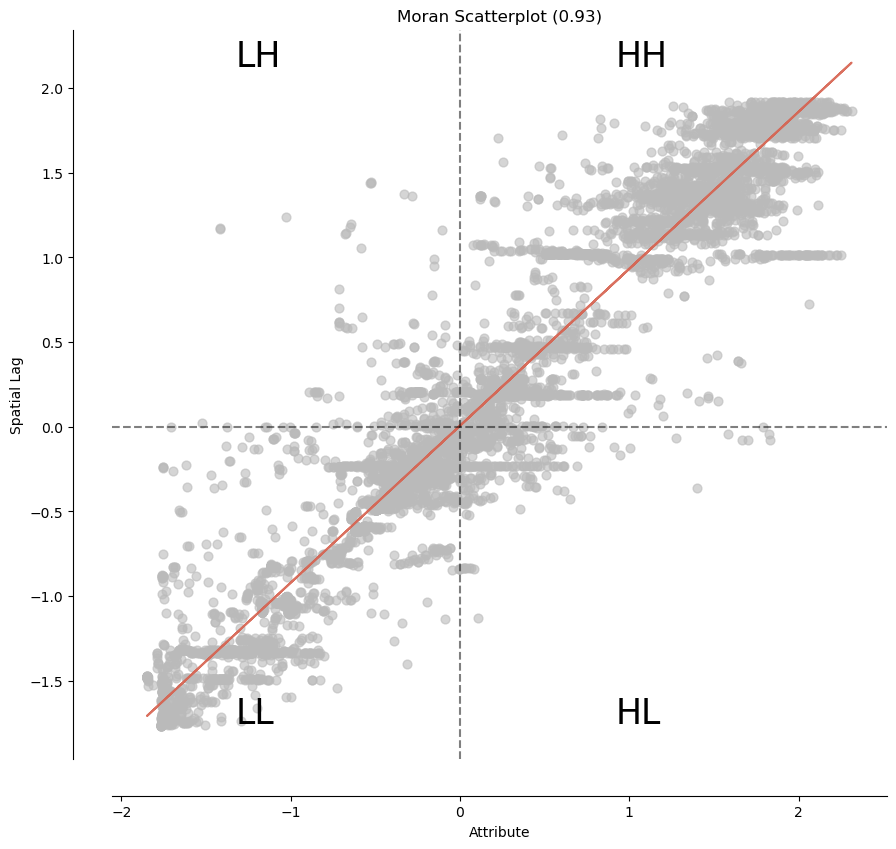

In [12]:
f,ax=plt.subplots(figsize=(10,10))
moran_scatterplot(moran, p=0.05, ax=ax, aspect_equal=True)
ax.text(0.16, 0.95, "LH", transform=ax.transAxes, fontsize=25)
ax.text(0.65, 0.95, "HH", transform=ax.transAxes, fontsize=25)
ax.text(0.16, 0.05, "LL", transform=ax.transAxes, fontsize=25)
ax.text(0.65, 0.05, "HL", transform=ax.transAxes, fontsize=25)


### Spatial autocorrelation - Local Moran's I
#### We'll use the same sample and weights matrix as above

In [13]:
lisa = esda.Moran_Local(y, knn_w)

Text(-1, -2, 'LL')

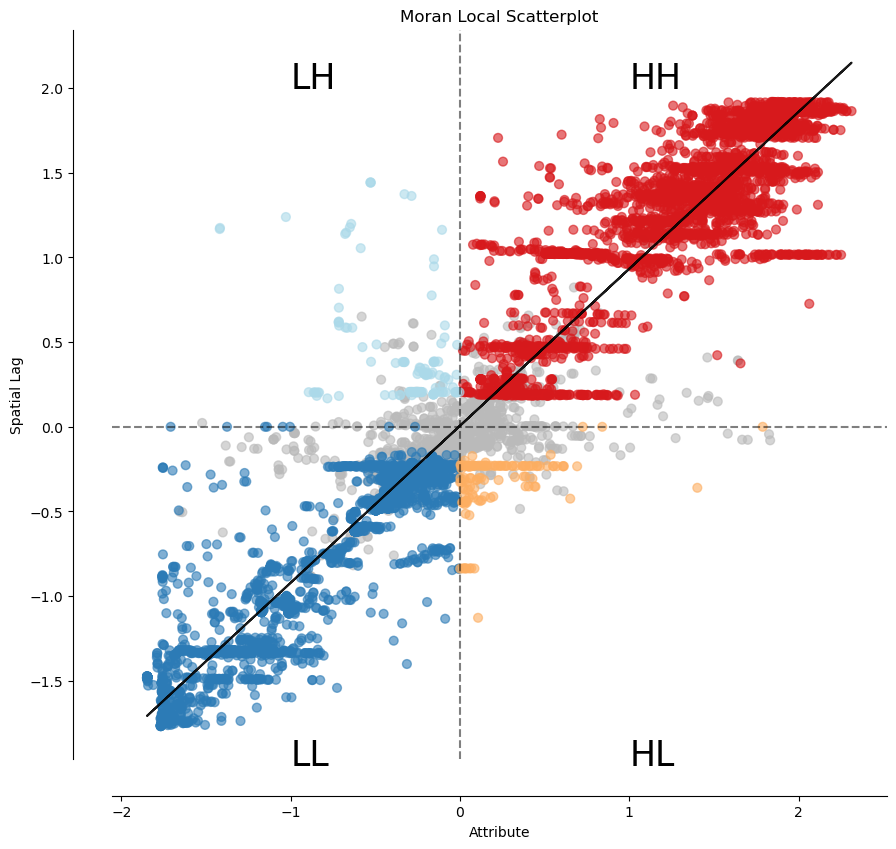

In [14]:
f,ax=plt.subplots(figsize=(10,10))
moran_scatterplot(lisa, p=0.05, ax=ax)
ax.text(1, 2, "HH", fontsize=25)
ax.text(1, -2, "HL", fontsize=25)
ax.text(-1, 2, "LH", fontsize=25)
ax.text(-1, -2, "LL", fontsize=25)

In [15]:
# Create a classification of significant Local Moran's I results
sig = 0.05
sig_lisa = lisa.p_sim < sig
hotspot = sig_lisa * (lisa.q == 1)  # High-High clusters
coldspot = sig_lisa * (lisa.q == 3)  # Low-Low clusters
doughnut = sig_lisa * (lisa.q == 2)  # Low-High outliers
diamond = sig_lisa * (lisa.q == 4)  # High-Low outliers

In [16]:
# Create a new GeoDataFrame with LISA results
glas_lisa = glas_sample.copy()
glas_lisa['lisa_p'] = lisa.p_sim
glas_lisa['lisa_q'] = lisa.q
glas_lisa['significant'] = sig_lisa
glas_lisa['cluster_type'] = 'Not Significant'
glas_lisa.loc[hotspot, 'cluster_type'] = 'High-High'
glas_lisa.loc[coldspot, 'cluster_type'] = 'Low-Low'
glas_lisa.loc[doughnut, 'cluster_type'] = 'Low-High'
glas_lisa.loc[diamond, 'cluster_type'] = 'High-Low'
glas_lisa

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,geometry,lisa_p,lisa_q,significant,cluster_type
15542,2004.429831,731738.318132,40.634266,-105.955516,3187.86,3189.93,13.01,12,POINT (446409.665 76585.637),0.001,1,True,High-High
5692,2003.766250,731495.681086,43.334905,-120.342822,1323.71,1324.80,1.15,31,POINT (-730844.923 402143.028),0.004,3,True,Low-Low
34538,2005.890662,732272.091524,39.276701,-106.181434,3889.66,3894.25,11.44,12,POINT (436063.724 -75975.063),0.001,1,True,High-High
14865,2004.409427,731730.850395,45.459046,-121.662681,890.63,872.95,0.72,31,POINT (-809285.618 649025.642),0.001,3,True,Low-Low
52951,2007.793761,732966.722938,35.047811,-119.473550,801.42,791.08,8.73,31,POINT (-745626.774 -525756.897),0.001,3,True,Low-Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,2003.853784,731527.631050,36.662171,-118.390415,3587.19,3592.78,4.88,31,POINT (-633135.494 -354993.718),0.001,1,True,High-High
35630,2006.163054,732371.514708,38.139578,-119.725524,2536.30,2532.79,8.94,31,POINT (-735984.476 -180594.846),0.001,1,True,High-High
42622,2006.474926,732485.347975,43.149502,-113.372769,1465.09,1463.40,0.24,31,POINT (-170174.25 346393.909),0.001,3,True,Low-Low
40746,2006.440673,732472.845738,39.985041,-113.675834,1282.22,1283.12,0.00,31,POINT (-204187.075 -6472.453),0.001,3,True,Low-Low


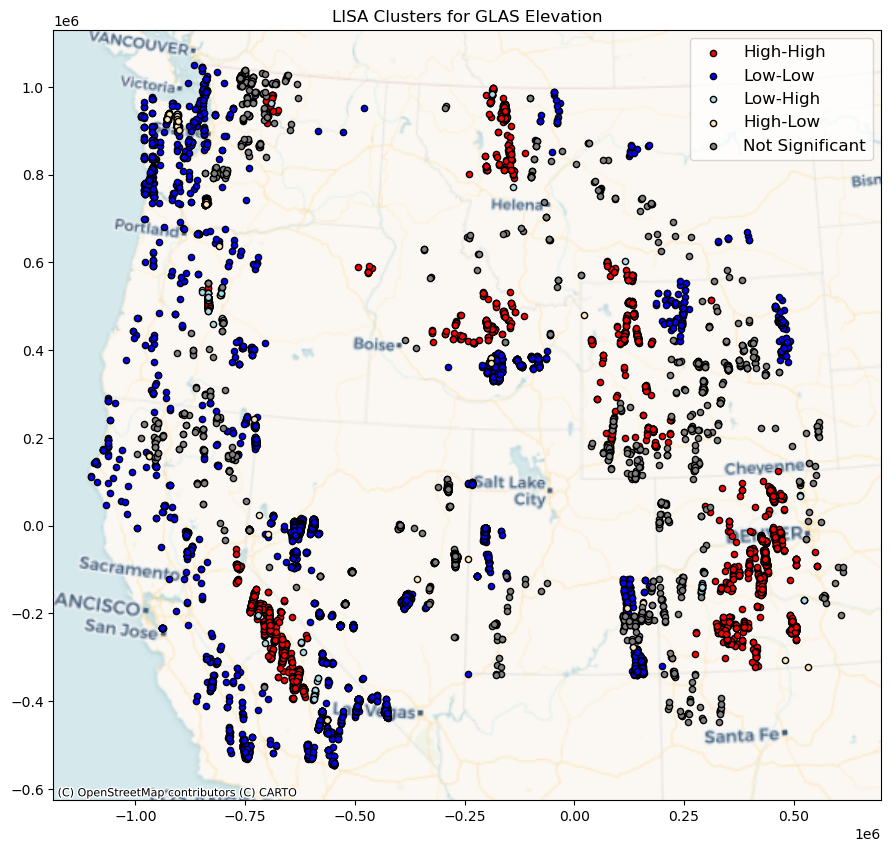

In [17]:
f, ax = plt.subplots(figsize=(15, 10))

# Plot only significant clusters with appropriate colors
colors = {'High-High': 'red', 'Low-Low': 'blue', 'Low-High': 'lightblue', 'High-Low': 'moccasin', 'Not Significant': 'gray'}
for cluster_type, color in colors.items():
    cluster_points = glas_lisa[glas_lisa['cluster_type'] == cluster_type]
    if len(cluster_points) > 0:
        cluster_points.plot(ax=ax, color=color, label=cluster_type, markersize=20, edgecolor='black')

ax.set_title('LISA Clusters for GLAS Elevation')
ax.legend(fontsize=12)

ctx.add_basemap(ax, crs=glas_gdf.crs, source=ctx.providers.CartoDB.Voyager)

In [18]:
# Calculate percentage of each cluster type
total_sig = sum(glas_lisa['significant'])
for cluster_type in ['High-High', 'Low-Low', 'Low-High', 'High-Low']:
    count = sum(glas_lisa['cluster_type'] == cluster_type)
    percent = count / total_sig * 100 if total_sig > 0 else 0
    print(f"{cluster_type}: {count} points ({percent:.1f}% of significant clusters)")

# Interpret results
print("\nInterpretation of LISA clusters:")
print("- High-High clusters (hotspots): Areas with high elevation surrounded by high elevation")
print("- Low-Low clusters (coldspots): Areas with low elevation surrounded by low elevation")
print("- Low-High outliers: Low elevation areas surrounded by high elevation (valleys)")
print("- High-Low outliers: High elevation areas surrounded by low elevation (peaks)")

High-High: 3036 points (35.7% of significant clusters)
Low-Low: 5211 points (61.3% of significant clusters)
Low-High: 134 points (1.6% of significant clusters)
High-Low: 115 points (1.4% of significant clusters)

Interpretation of LISA clusters:
- High-High clusters (hotspots): Areas with high elevation surrounded by high elevation
- Low-Low clusters (coldspots): Areas with low elevation surrounded by low elevation
- Low-High outliers: Low elevation areas surrounded by high elevation (valleys)
- High-Low outliers: High elevation areas surrounded by low elevation (peaks)


### Spatial autocorrelation: Variogram analysis
#### Now let's focus on a smaller region around Wyoming

In [19]:
#sierras_gdf = gpd.GeoDataFrame(geometry=[Polygon([(-120, 35), (-115, 35), (-115, 41), (-120, 41)])], crs='EPSG:4326') sierras_gdf = sierras_gdf.to_crs(WUS_aea_crs)
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
wa_state_gdf = states_gdf.loc[states_gdf['NAME'] == 'Wyoming']
wa_state_gdf = wa_state_gdf.to_crs(WUS_aea_crs)
wa_glas_gdf = glas_gdf.clip(wa_state_gdf.geometry)
wa_glas_gdf

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,geometry
62340,2008.957958,733392.612512,41.246035,-109.477271,1933.91,1932.70,2.55,31,POINT (149271.215 133209.437)
17403,2004.466642,731751.790861,41.254643,-109.496467,1951.60,1950.47,8.84,31,POINT (147653.616 134139.503)
17404,2004.466642,731751.790861,41.257727,-109.497060,1932.47,1935.36,8.08,31,POINT (147597.42 134483.139)
55604,2007.841519,732984.154510,41.086350,-109.433132,2122.50,2126.97,9.19,31,POINT (153312.722 115440.406)
14873,2004.410758,731731.337459,42.017654,-109.413979,1989.46,1990.01,0.10,31,POINT (152755.811 219532.112)
...,...,...,...,...,...,...,...,...,...
8927,2003.845505,731524.609145,44.977203,-108.039953,1580.09,1576.41,6.44,31,POINT (253923.854 552915.201)
36995,2006.198541,732384.467417,44.977144,-108.033952,1658.68,1661.88,11.17,31,POINT (254395.712 552925.655)
8926,2003.845505,731524.609145,44.978749,-108.039639,1666.83,1662.22,12.32,31,POINT (253942.319 553088.305)
23819,2005.176556,732011.442943,44.832693,-108.699409,1380.74,1380.29,4.05,31,POINT (202552.643 535133.893)


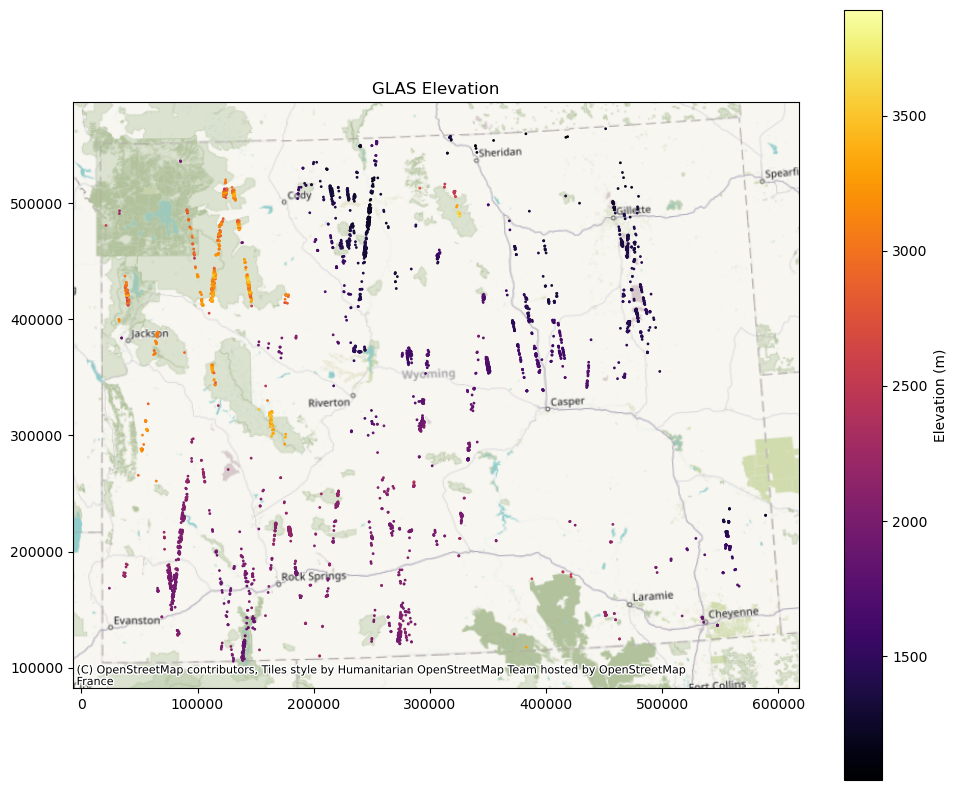

In [20]:
f,ax=plt.subplots(figsize=(10,8))

wa_glas_gdf.plot(ax=ax,column='glas_z',cmap='inferno',legend=True,markersize=1,legend_kwds={'label': "Elevation (m)"})
ctx.add_basemap(ax,crs=wa_glas_gdf.crs.to_string())

ax.set_aspect('equal')

ax.set_title('GLAS Elevation')

f.tight_layout()

In [21]:
wa_sample_size = min(10000, len(wa_glas_gdf))  # Adjust based on computational resources
wa_glas_sample = wa_glas_gdf.sample(wa_sample_size, random_state=42)

Calculating empirical variogram...
Fitting variogram model...


/home/eric/miniconda3/envs/uwgda2025/lib/python3.12/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


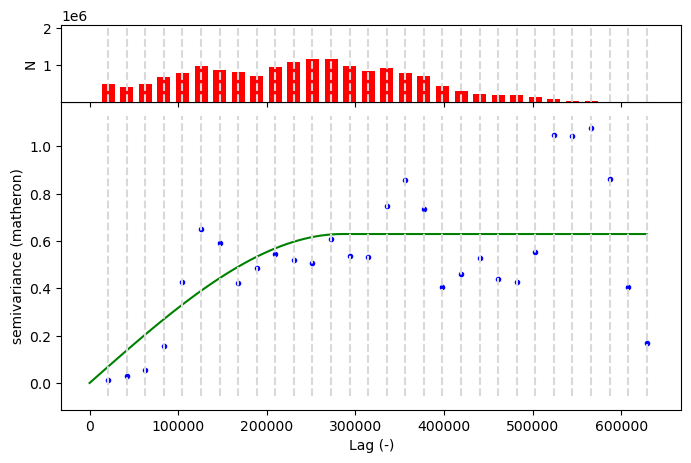

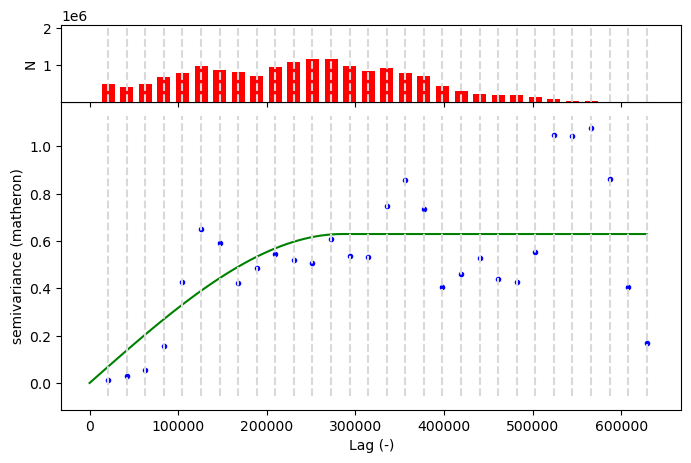

In [22]:
coords = np.vstack((wa_glas_sample.geometry.x, wa_glas_sample.geometry.y)).T
values = wa_glas_sample['glas_z'].values

# Create a variogram object
print("Calculating empirical variogram...")
V = skg.Variogram(
    coords, 
    values,
    model='spherical',  # Starting with a spherical model
    n_lags=30,          # Number of distance classes
    maxlag='auto',       # Maximum lag distance
    use_nugget=True     # Include a nugget effect
)

# Fit the variogram model
print("Fitting variogram model...")
V.fit()
V.plot()

In [23]:
# Print variogram parameters
print("Variogram Model Parameters:")
print(f"Model type: {V.describe()['model']}")
print(f"Nugget: {V.describe()['nugget']:.4f}")
print(f"Sill: {V.describe()['sill']:.4f}")
print(f"Effective range: {V.describe()['effective_range']:.4f} meters")

Variogram Model Parameters:
Model type: spherical
Nugget: 0.0000
Sill: 629197.7526
Effective range: 285190.7617 meters


In [24]:
# Variogram model interpretation
print("\nVariogram Interpretation:")
print(f"Nugget/Sill Ratio: {V.describe()['nugget'] / V.describe()['sill'] * 100:.1f}%")
if V.describe()['nugget'] / V.describe()['sill'] < 0.25:
    print("Low Nugget/Sill ratio indicates strong spatial dependence")
elif V.describe()['nugget'] / V.describe()['sill'] < 0.75:
    print("Moderate Nugget/Sill ratio indicates moderate spatial dependence")
else:
    print("High Nugget/Sill ratio indicates weak spatial dependence")
print(f"Range indicates that spatial dependence extends to approximately {V.describe()['effective_range']:.4f} meters")


Variogram Interpretation:
Nugget/Sill Ratio: 0.0%
Low Nugget/Sill ratio indicates strong spatial dependence
Range indicates that spatial dependence extends to approximately 285190.7617 meters


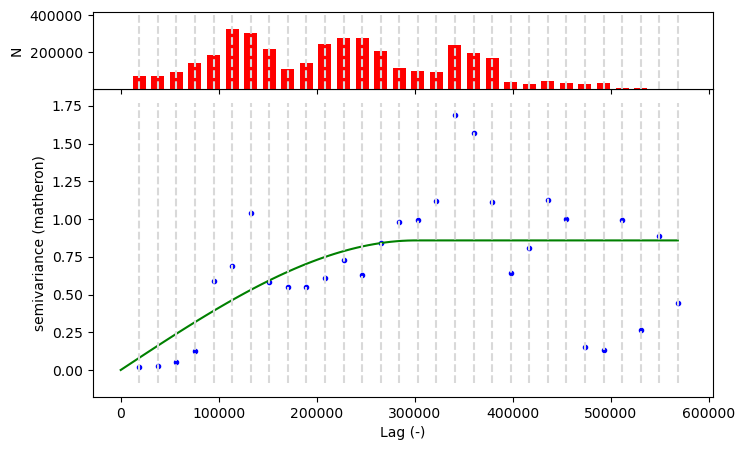

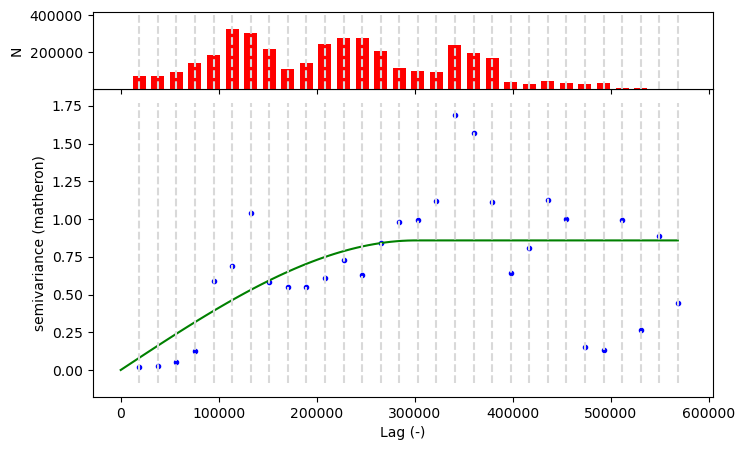

In [25]:
DV = skg.DirectionalVariogram(
    coords, values, azimuth=0, tolerance=45, directional_model="triangle", n_lags=30, model="spherical", maxlag="auto", use_nugget=True,
)
DV.fit()
DV.plot()

### Interpretation time! Why does the variogram go back down at large lag distances??

### Now let's try some spatial interpolation
#### First, let's try a couple of deterministic approaches

In [26]:
dem_da = easysnowdata.topography.get_copernicus_dem(bbox_input=wa_state_gdf.to_crs('EPSG:4326'),resolution=90).load()
dem_da = dem_da.rio.reproject(WUS_aea_crs,resolution=(2000,2000),resampling=rasterio.enums.Resampling.average)
dem_da

<xarray.DataArray 'data' (y: 236, x: 294)> Size: 278kB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [2213.9897, 2170.1924, 2246.1716, ...,       nan,       nan,
              nan],
       [2175.605 , 2157.7988, 2298.4368, ...,       nan,       nan,
              nan],
       [2162.1846, 2168.7817, 2274.622 , ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * x            (x) float64 2kB 1.77e+04 1.97e+04 ... 6.017e+05 6.037e+05
  * y            (y) float64 2kB 5.734e+05 5.714e+05 ... 1.054e+05 1.034e+05
    time         datetime64[ns] 8B 2021-04-22
    spatial_ref  int64 8B 0

In [27]:
x = wa_glas_gdf['geometry'].x
y = wa_glas_gdf['geometry'].y
z = wa_glas_gdf['glas_z']
bounds = wa_glas_gdf.total_bounds
dx,dy = (2000,2000)

In [28]:
mpl_extent = (bounds[0],bounds[2],bounds[1],bounds[3])

In [29]:
xi = np.arange(np.floor(bounds[0]), np.ceil(bounds[2]),dx)
#yi = np.arange(np.floor(bounds[1]), np.ceil(bounds[3]),dy)
yi = np.arange(np.ceil(bounds[3]),np.floor(bounds[1]),-dy)
xx, yy = np.meshgrid(xi, yi)


In [30]:
interp_nearest = scipy.interpolate.griddata((x,y), z, (xx, yy), method='nearest')
interp_linear = scipy.interpolate.griddata((x,y), z, (xx, yy), method='linear')
interp_cubic = scipy.interpolate.griddata((x,y), z, (xx, yy), method='cubic')
interp_func_rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
interp_rbf = interp_func_rbf(xx, yy)

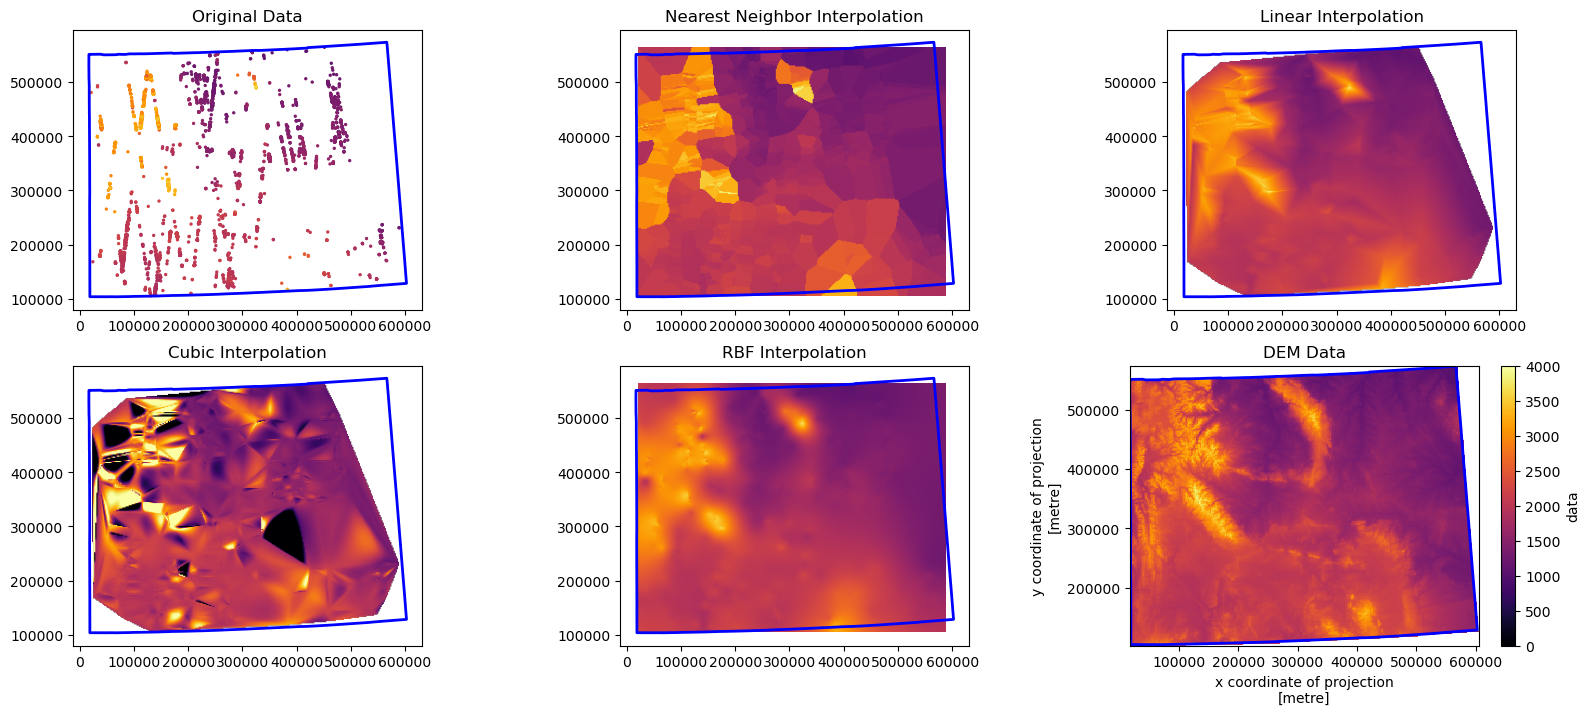

In [31]:
f,axs=plt.subplots(2,3,figsize=(20,8))
wa_glas_gdf.plot(ax=axs[0,0],column='glas_z',cmap='inferno',vmin=0,vmax=4000, markersize=2)#,legend=True,markersize=1,legend_kwds={'label': "Elevation (m)"})
axs[0,0].set_title('Original Data')
axs[0,0].set_aspect('equal')

axs[0,1].imshow(interp_nearest,extent=(bounds[0],bounds[2],bounds[1],bounds[3]),cmap='inferno',vmin=0,vmax=4000)
axs[0,1].set_title('Nearest Neighbor Interpolation')
axs[0,1].set_aspect('equal')  

axs[0,2].imshow(interp_linear,extent=(bounds[0],bounds[2],bounds[1],bounds[3]),cmap='inferno',vmin=0,vmax=4000)
axs[0,2].set_title('Linear Interpolation')
axs[0,2].set_aspect('equal')

axs[1,0].imshow(interp_cubic,extent=(bounds[0],bounds[2],bounds[1],bounds[3]),cmap='inferno',vmin=0,vmax=4000)
axs[1,0].set_title('Cubic Interpolation')
axs[1,0].set_aspect('equal')

axs[1,1].imshow(interp_rbf,extent=(bounds[0],bounds[2],bounds[1],bounds[3]),cmap='inferno',vmin=0,vmax=4000)
axs[1,1].set_title('RBF Interpolation')
axs[1,1].set_aspect('equal')

dem_da.plot.imshow(ax=axs[1,2],cmap='inferno',vmin=0,vmax=4000)
axs[1,2].set_title('DEM Data')
axs[1,2].set_aspect('equal')

for ax in axs.flat:
    wa_state_gdf.boundary.plot(ax=ax,color='blue',linewidth=2)


### And now we'll try a geostatistical method for interpolation, Ordinary Kriging

In [32]:
ok = skg.OrdinaryKriging(DV, min_points=10, max_points=30, mode='exact') # try V or DV!

In [33]:
# build the target grid
coords = np.stack([wa_glas_gdf.geometry.x.values, wa_glas_gdf.geometry.y.values], axis=1)
col = 'glas_z'
vals = wa_glas_gdf[col].values
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

/tmp/ipykernel_3086994/3288337770.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbars


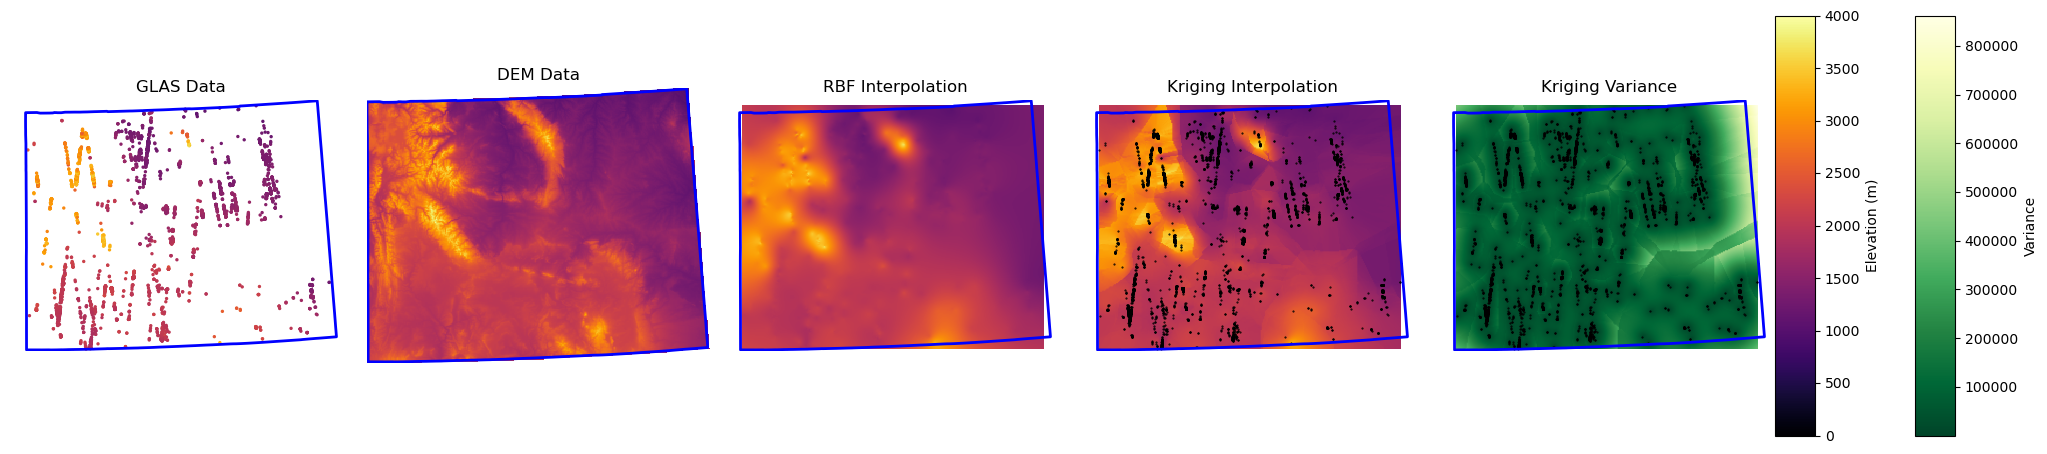

In [34]:
f, axs = plt.subplots(1, 5, figsize=(20, 6), sharey=True)

# Plot GLAS Data
wa_glas_gdf.plot(ax=axs[0], column='glas_z', cmap='inferno', vmin=0, vmax=4000, markersize=2)
axs[0].set_title('GLAS Data')
axs[0].set_aspect('equal')

# Plot DEM Data
dem_da.plot.imshow(ax=axs[1], cmap='inferno', vmin=0, vmax=4000, add_colorbar=False)
axs[1].set_title('DEM Data')
axs[1].set_aspect('equal')

# Plot RBF Interpolation
im_rbf = axs[2].imshow(interp_rbf, extent=(bounds[0], bounds[2], bounds[1], bounds[3]), cmap='inferno', vmin=0, vmax=4000)
axs[2].set_title('RBF Interpolation')
axs[2].set_aspect('equal')

# Plot Kriging Interpolation
im_kriging = axs[3].imshow(field, vmin=0, vmax=4000, cmap='inferno', extent=mpl_extent)
axs[3].set_title('Kriging Interpolation')
axs[3].set_aspect('equal')
axs[3].plot(coords[:, 0], coords[:, 1], 'k.', markersize=1)


# Plot Kriging Variance
im_variance = axs[4].imshow(s2, cmap='YlGn_r', extent=mpl_extent)
axs[4].set_title('Kriging Variance')
axs[4].set_aspect('equal')
axs[4].plot(coords[:, 0], coords[:, 1], 'k.', markersize=1)

# Add state boundary to all plots
for ax in axs.flat:
    wa_state_gdf.boundary.plot(ax=ax, color='blue', linewidth=2)
    ax.axis('off')

# Add colorbars
cbar_ax1 = f.add_axes([0.89, 0.15, 0.02, 0.7])  # Position for inferno colorbar
cbar_ax2 = f.add_axes([0.96, 0.15, 0.02, 0.7])  # Position for YlGn_r colorbar

f.colorbar(im_rbf, cax=cbar_ax1, label='Elevation (m)')
f.colorbar(im_variance, cax=cbar_ax2, label='Variance')

f.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbars

### Why might Kriging perform poorly here? What locations seem to match best / worst with the DEM?